In [1]:
include("../src/vafdyn.jl")
using .VAFDyn
using OrdinaryDiffEq, Distances, Distributions
using JLD2
using ApproxBayes

In [27]:
using Plots
# plotlyjs()
gr()

Plots.GRBackend()

In [9]:
# create reference measurement:
paramsTrue = Dict(
    "N"=>300,
    "ρ"=>1.0,
    "ϕ"=>3.0,
    "μ"=>4.2
)
evolveTime = 59
# sampleSize = 89

function mutBurdenStats(params, evolveTime)
    ρ = params["ρ"]
    ϕ = params["ϕ"]
    λ = ρ + ϕ
    p = 1/(ρ/ϕ+1)
    t = evolveTime
    μ = params["μ"]
    mean = λ*(2-p)*t*μ
    var = λ*(2-p)*t*(μ+μ^2)
    return mean, var
end

display(paramsTrue)
println(mutBurdenStats(paramsTrue, evolveTime))

Dict{String,Real} with 4 entries:
  "μ" => 4.2
  "N" => 300
  "ρ" => 1.0
  "ϕ" => 3.0

(1239.0, 6442.8)


In [56]:
mutMean, mutVar = mutBurdenStats(paramsTrue, evolveTime)

vfsTrue = VAFDyn.VFreqspace(paramsTrue["N"], 101)
println("evolving true vaf...")
@time VAFDyn.evolveVAF(vfsTrue, paramsTrue, evolveTime)

reference_f = vfsTrue.n_f[2:end-1];

evolving true vaf...
  0.013474 seconds (12.74 k allocations: 2.241 MiB)


In [65]:
#simulations function for ABC. return distance (sum of squared distances) and solution
function simLV(paramsEst, constants, targetdata)
    p = paramsEst[2]
    t = evolveTime
    λ = mutMean^2 / ((mutVar - mutMean)*(2-p)*t)
    params = Dict(
        # "N"=> paramsTrue["N"],
        "N" => Int(round(paramsEst[1])),
        "ρ" => λ*(1-p),
        "ϕ" => λ*p,
        "μ" => (mutVar-mutMean)/mutMean
    )
    vfs = VAFDyn.VFreqspace(params["N"], 101)
    VAFDyn.evolveVAF(vfs, params, evolveTime)

    d = sum(  ( (vfs.n_f[2:end-1] .- reference_f) ./ (vfs.n_f[2:end-1]) ).^2  )
#     println( (vfs.n_f[2:end-1] .- reference_f)[1:5])
#     println(reference_f[1:5])
#     println(vfs.n_f[2:end-1][1:5])
#     println(d)
    return d, 1
end

#define ABC setup type
setup = ABCRejection(
    simLV,
    2,
    5.,
    Prior([DiscreteUniform(100, 1000), Uniform(0.001, 0.999)]),
    maxiterations = 1*10^4,
    nparticles = 100
    )

println("running ABC")
#run ABC SMC algorithm
@time simResult = runabc(setup, reference_f, verbose=true, progress=true, parallel=true)

println("finished ABC")
#show results
show(simResult)

running ABC
Preparing to run in parallel on 1 processors
 87.520658 seconds (104.38 M allocations: 17.648 GiB, 4.65% gc time)
finished ABC
Number of simulations: 7.93e+03
Acceptance ratio: 1.26e-02

Median (95% intervals):
Parameter 1: 343.50 (250.00,437.62)
Parameter 2: 0.69 (0.59,0.79)


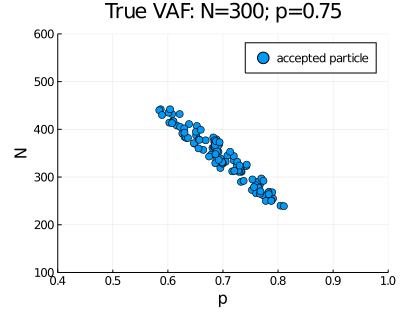

In [70]:
param1Accepted_part = []
param2Accepted_part = []

for particle in simResult.particles
    push!(param1Accepted_part, particle.params[1])
    push!(param2Accepted_part, particle.params[2])
end

# h1 = histogram(param1Accepted_part, label="", color=1, bins=20)
# xlabel!("N")
# ylabel!("accepted values")
# h2 = histogram(param2Accepted_part, label="", color=2, bins=20)
# xlabel!("p")
# # ylabel!("accepted values")
# p1 = plot(h1, h2, layout=2)

scale = 0.8

p2 = scatter(param2Accepted_part, param1Accepted_part, label="accepted particle", 
    size=(500*scale,400*scale))
xlabel!("p")
ylabel!("N")
xlims!(0.4,1)
ylims!(100, 600)
title!("True VAF: N=300; p=0.75")

# p3 = plot(p1, p2, layout=(2,1), size=(600, 800))

display(p2)

savefig(p2, "ABCresult_N-p_Unsampled.pdf")